In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


#Don't need t=0.
df = pd.read_csv('../Data/ApixibanExperimentData.csv')
df.Concentration = 10e-3*df.Concentration

#Create a table of data. Subjects x Time
Ys = df.query('Time>0').pivot('Subject','Time','Concentration')
Y = Ys.values

t = np.array([0.5, 1 ,2 ,4 ,6 ,8 ,10 ,12])

#Vectorize the function
@np.vectorize
def func(t,V,k,k_a):
    return (2.5/V)*(k_a/(k_a- k))*(np.exp(-k * t) - np.exp(-k_a * t))


YHAT = np.zeros(shape = Y.shape)

for i,y in enumerate(Y):

    p,c = curve_fit(func,xdata=t,ydata=y, p0= [100,1,1/2], bounds=(3*[0], 3*[np.inf]))

    y_hat = func(t,*p)
    
    YHAT[i,:] = y_hat
    


In [2]:
preds = pd.DataFrame(YHAT, index=Ys.index, columns=Ys.columns).stack().to_frame('predicted').reset_index()

In [3]:
m = preds.merge(df, on=['Subject','Time'], how = 'inner')

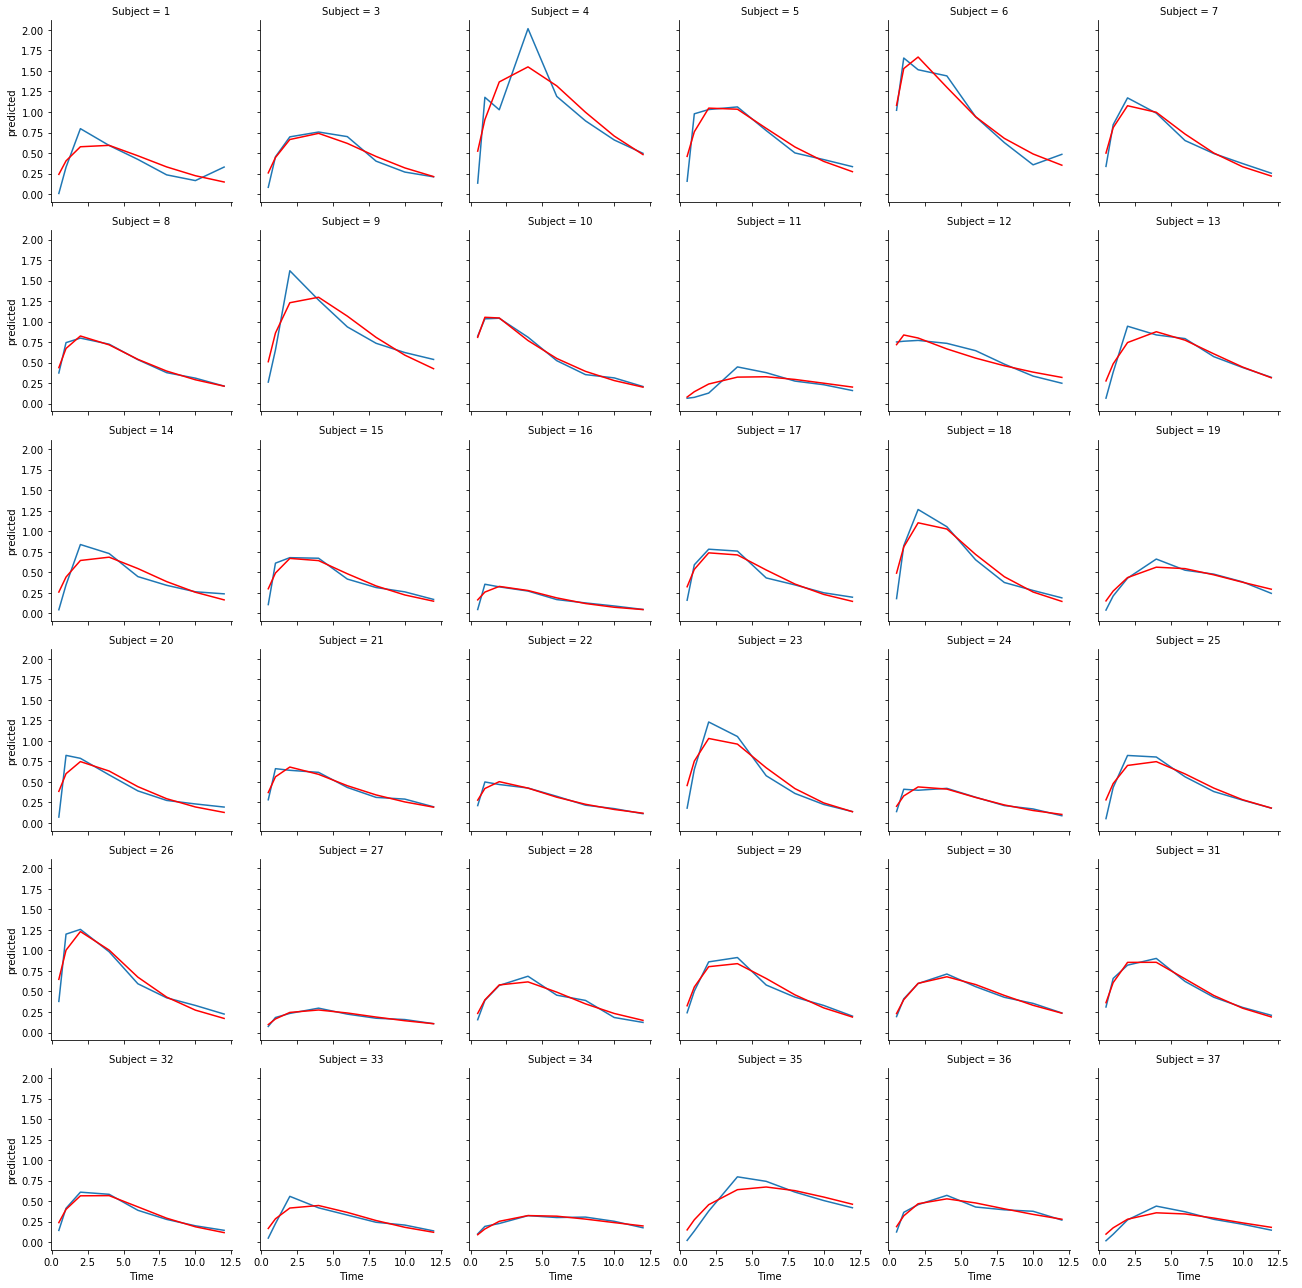

In [4]:
g = sns.FacetGrid(data = m, col = 'Subject', col_wrap=6)

g.map(plt.plot,'Time','Concentration').add_legend()
g.map(plt.plot,'Time','predicted', color = 'red')

In [5]:
m['residual'] = m.Concentration - m.predicted

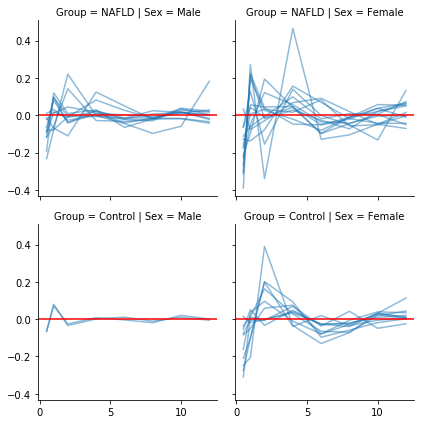

In [6]:

g = sns.FacetGrid(data = m, col='Sex', row = 'Group')


def f(x,y,z,*args,**kwargs):
    
    return sns.lineplot(x = x, 
                        y = y,
                        units = z,
                        estimator = None,
                        *args, 
                        **kwargs)


g.map(f, 'Time','residual','Subject', alpha = 0.5)
g.map(plt.axhline,color = 'red')
plt.tight_layout()

plt.savefig("1comp.pdf")

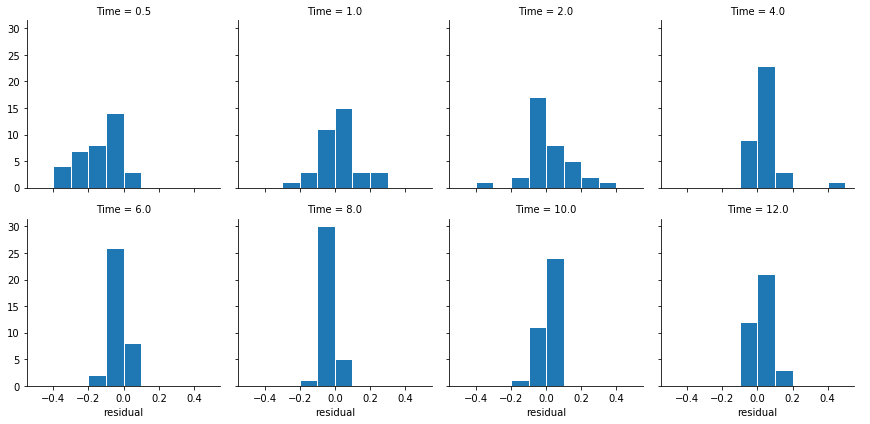

In [7]:
g = sns.FacetGrid(data = m, col='Time', col_wrap=4)

g.map(plt.hist,'residual', bins = np.linspace(-0.5,0.5,11), edgecolor = 'white').add_legend()

plt.tight_layout()
plt.savefig('res.pdf')


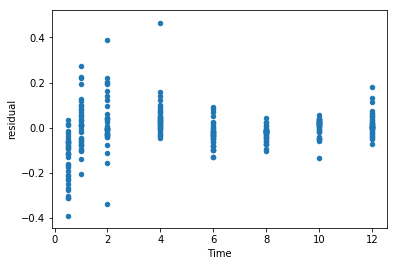

In [8]:
ax = m.plot.scatter(x = 'Time', y = 'residual')


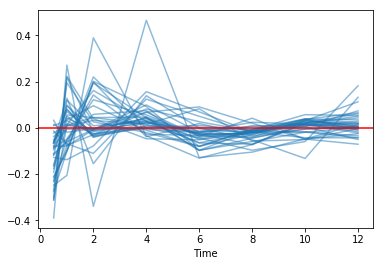

In [9]:
ax = m.pivot('Time','Subject','residual').plot(color = 'C0', legend = False, alpha = 0.5)
ax.axhline(0, color = 'red')


/Users/demetri/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


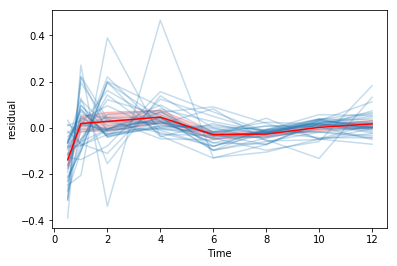

In [10]:
sns.lineplot(data = m, x = 'Time',y = 'residual', units = 'Subject', estimator=None, alpha = 0.25)
sns.lineplot(data = m, x = 'Time',y = 'residual', color = 'red')

In [11]:
m.round(2).to_clipboard(index = False)

In [13]:
m.groupby(['Sex','Group']).Subject.nunique()

Sex     Group  
Female  Control    10
        NAFLD      13
Male    Control     2
        NAFLD      11
Name: Subject, dtype: int64

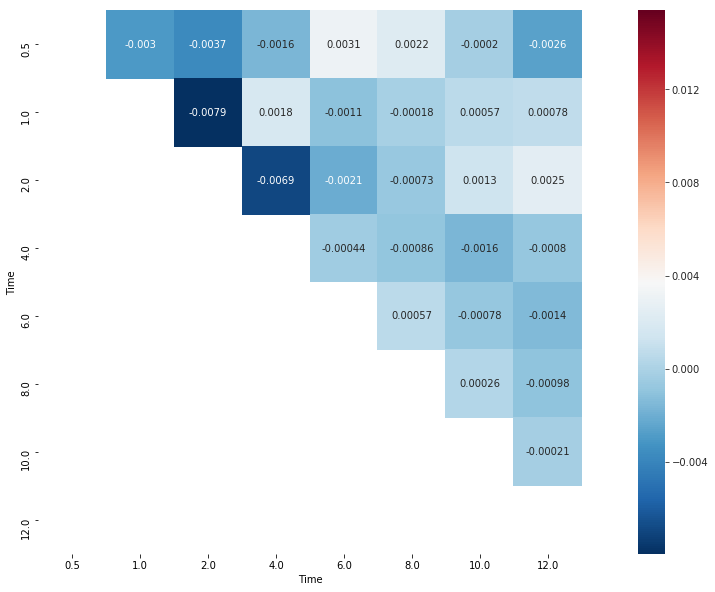

In [37]:
corr = m.pivot('Subject','Time','residual').cov()

fig, ax = plt.subplots(figsize = (20,10))

mask = np.zeros_like(corr)
mask[np.tril_indices_from(mask)] = True
with sns.axes_style("white"):
    sns.heatmap(C, cmap = 'RdBu_r', annot = True,square=True,mask=mask)